In [70]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import numpy as np

import itertools

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics

In [2]:
## Helper functions

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Project 4: NLP, NLP, NLP

We will be doing three classifications and attempt to kill two ~~birds~~ questions with one ~~stone~~ classification model - which is Question 1 and Question 2, Number (2). So, I won't be going through the project in the same order of the Questions. Sorry.

## Bringing in my tables from SQL

In [3]:
connection = sqlite3.connect('job_scraped.db.sqlite')

In [4]:
sql_query = '''
SELECT *
FROM jobs
'''

In [5]:
df = pd.read_sql(sql_query, con=connection)

In [6]:
df.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
2,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst


In [7]:
# Check for duplicates
df['id'].duplicated(keep='first').sum()

0

Hurray! No duplicates!

## 1) Data Scientists versus others
What components of a job posting distinguish data scientists from other data jobs?

### Data Scientist vs Data Analyst vs Data Engineer

In [8]:
# Extracting all jobs with "Data Science" in the title

only_ds = df[df['title'].isin(['Data Scientist'])].copy()
only_ds['label'] = 'DS'

In [9]:
only_da = df[df['title'].isin(['Data Analyst'])].copy()
only_da['label'] = 'DA'

In [10]:
only_de = df[df['title'].isin(['Data Engineer'])].copy()
only_de['label'] = 'DE'

In [11]:
ds_vs_others = pd.concat([only_ds,only_da,only_de], ignore_index=True)

# Dropping ID and Title because we don't need thouse anymore.
ds_vs_others.drop(columns=['id','title'], inplace=True)

In [12]:
ds_vs_others.head()

,description,label
0,PURPOSE OF THE ROLE\nThis role of a data scien...,DS
1,Work cross-functionally with business managers...,DS
2,Serve as primary source of data insights suppo...,DS
3,"Big data, artificial intelligence and advanced...",DS
4,As the innovation leader in the logistics indu...,DS


In [13]:
ds_vs_others['label'].value_counts()

DS    26
DE    23
DA    18
Name: label, dtype: int64

WOOT! I have a balanced dataset :) albeit small.... but let's see if we can infer anything from it using NLP.

### Simple cleaning, no stemming or lemmitization or removal of stop words because it is so small (rows = 60+).

In [14]:
# Removing punctuation, numbers and lowercase all
ds_vs_others['clean'] = ds_vs_others['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [15]:
ds_vs_others.head()

,description,label,clean
0,PURPOSE OF THE ROLE\nThis role of a data scien...,DS,purpose of the role this role of a data scient...
1,Work cross-functionally with business managers...,DS,work cross functionally with business managers...
2,Serve as primary source of data insights suppo...,DS,serve as primary source of data insights suppo...
3,"Big data, artificial intelligence and advanced...",DS,big data artificial intelligence and advanced...
4,As the innovation leader in the logistics indu...,DS,as the innovation leader in the logistics indu...


In [16]:
X = ds_vs_others['clean']
y = ds_vs_others['label']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [96]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', SGDClassifier())
])

In [97]:
model = pipe.fit(X_train, y_train)

In [98]:
vectorizer = model.named_steps['vectorizer']
clf = model.named_steps['clf']

In [99]:
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

In [100]:
target_names = ['DA', 'DE', 'DS'] # alphabetical
print("Top 10 keywords per class \n")
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print("%s: %s" % (label, ", ".join(feature_names[top10])))

Top 10 keywords per class 

DA: data analyst, analyst, understanding, analytic, real, viki, work, real estate, estate, team
DE: tools, knowledge, building, role, range, data engineer, solutions, development, engineering, engineer
DS: machine, machine learning, learning, digital, data science, insights, science, analytics, models, statistical


In [101]:
y_pred = pipe.predict(X_test)

Confusion matrix, without normalization
[[ 1  5  3]
 [ 0 11  0]
 [ 0  4 10]]


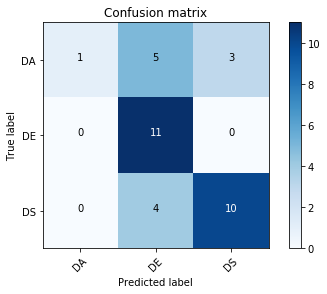

In [102]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), classes=['DA', 'DE', 'DS'], title='Confusion matrix')

Yup, as expected. Because DA's top 10 keywords had company names in the mix which of course will through it off course quite fast and easily.

In [ ]:
# pipe = Pipeline([
#     ('vectorizer': CountVectorizer()),
#     ('tfidfTrans': TfidfTransformer()),
#     ('clf': SGDClassifier())
# ])

## 2) What features are important for distinguishing junior vs. senior positions? And how does this predict salaries?

In [ ]:
# # initialize stemmer
# stemmer = SnowballStemmer('english')

# # stem each word
# print [stemmer.stem(word) for word in review.words]